In [17]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from libs.MarkovModel import compute_context_aware_transition_matrix
from libs.MarkovModel import compute_transition_matrix
from libs.MarkovModel import compute_log_likelihood_and_perplexity
from libs import encode_float_filename, decode_float_filename, generate_balanced_thresholds, assign_groups

In [18]:
import numpy as np

def compute_aggregate_TransM(P, mapping):
    """
    Computes the new transition matrix P(y' | y) based on the mapping from x to y.

    Parameters:
    - P (np.ndarray): The original transition matrix P(x' | x) of shape (L, L).
    - mapping (np.ndarray): The mapping array of length L, where mapping[i] is the y-value of x=i.

    Returns:
    - np.ndarray: The new transition matrix P(y' | y).
    """
    unique_y = np.unique(mapping)
    num_y = len(unique_y)
    P_y = np.zeros((num_y, num_y))

    for y in unique_y:
        for y_prime in unique_y:
            S_y = np.where(mapping == y)[0]
            S_y_prime = np.where(mapping == y_prime)[0]
            total_prob = 0
            for x in S_y:
                for x_prime in S_y_prime:
                    total_prob += P[x_prime, x]

            # Directly assigning the total probability
            P_y[np.where(unique_y == y)[0], np.where(unique_y == y_prime)[0]] = total_prob

    # Normalize each row to ensure it is a valid transition matrix
    row_sums = P_y.sum(axis=1, keepdims=True)
    P_y = np.divide(P_y, row_sums, where=row_sums != 0)

    return P_y

# Example usage
P_example = np.array([
    [0.2, 0.3, 0.5, 0.0],
    [0.1, 0.6, 0.2, 0.1],
    [0.4, 0.3, 0.2, 0.1],
    [0.3, 0.2, 0.3, 0.2]
])

mapping_example = np.array([0, 0, 0, 1])  # x -> y mapping

P_y_example = compute_aggregate_TransM(P_example, mapping_example)

print("Aggregated Transition Matrix P(y' | y):")
print(P_y_example)


Aggregated Transition Matrix P(y' | y):
[[0.77777778 0.22222222]
 [0.5        0.5       ]]


In [19]:
dbParams_list = [0.01, 0.15]
direction_list = ["forward", "backward"]
mode_list = ["fixed", "adaptive"]
lenWindow_list = [10, 20, 30]
N_group_list = [3,4,4]
verbose = False


perpCF_results = {}
perpCA_results = {}

for dbParams, direction in zip(dbParams_list, direction_list):
    for mode in mode_list:
        perpCF_row = []
        perpCA_row = []
        for lenWindow, N_group in zip(lenWindow_list, N_group_list):
            dbpString = encode_float_filename(dbParams)
            with open(f"Results/TrafficPredictor/evaluate/CA/{direction}_{lenWindow}_{mode}_{dbpString}_train.pkl", "rb") as file:
                resultsTrain = pickle.load(file)
            with open(f"Results/TrafficPredictor/evaluate/CA/{direction}_{lenWindow}_{mode}_{dbpString}_test.pkl", "rb") as file:
                resultsTest = pickle.load(file)

                N_group = 3
                thereshold_Train = generate_balanced_thresholds(resultsTrain['trafficTarget_actual'].astype(int), N_group)
                mapping = assign_groups(np.array(range(0, lenWindow+1)), thereshold_Train)
                print(f"Theres:{thereshold_Train}, Mapping:{mapping}")

                trafficSource = assign_groups(resultsTrain['trafficSource_actual'].astype(int), thereshold_Train)
                trafficTarget = assign_groups(resultsTrain['trafficTarget_actual'].astype(int), thereshold_Train)
                transMatrixContextFree = compute_transition_matrix(trafficSource, trafficTarget, lenWindow, alpha=1e-20)
                
                N = 1
                sourceTraffic = assign_groups(resultsTest['trafficSource_actual'].astype(int), thereshold_Train)
                targetTraffic = assign_groups(resultsTest['trafficTarget_actual'].astype(int), thereshold_Train)
                logLikeCF, perpCF = compute_log_likelihood_and_perplexity(transMatrixContextFree, sourceTraffic, targetTraffic, N=N)

            perpCF_row.append(np.mean(perpCF))
            perpCA_row.append(np.mean(perpCF))

        perpCF_results[(direction, mode)] = np.array(perpCF_row)
        perpCA_results[(direction, mode)] = np.array(perpCA_row)  

#perpCF_results = np.array(perpCF_results)
#perpCA_results = np.array(perpCA_results)


Theres:[1, 3], Mapping:[0 0 1 1 2 2 2 2 2 2 2]
Theres:[3, 7], Mapping:[0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
Theres:[5, 10], Mapping:[0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Theres:[1, 3], Mapping:[0 0 1 1 2 2 2 2 2 2 2]
Theres:[3, 6], Mapping:[0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Theres:[4, 8], Mapping:[0 0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Theres:[1, 3], Mapping:[0 0 1 1 2 2 2 2 2 2 2]
Theres:[3, 7], Mapping:[0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
Theres:[6, 11], Mapping:[0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Theres:[1, 3], Mapping:[0 0 1 1 2 2 2 2 2 2 2]
Theres:[3, 7], Mapping:[0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
Theres:[5, 10], Mapping:[0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


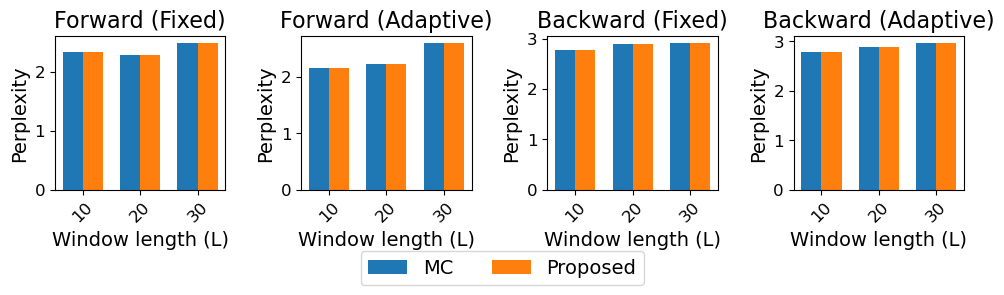

In [20]:
def plot_combined_comparison_bar_graph(perpCF_results: dict, perpCA_results: dict, configurations, subtitles, figsize=(12, 12), 
                                       title_fontsize=14, label_fontsize=12, tick_fontsize=10, legend_fontsize=12) -> None:
    # Creating the figure with 1x4 subplots
    fig, axs = plt.subplots(1, 4, figsize=figsize)
    axs = axs.ravel()  # Flatten for easier indexing

    for i, config in enumerate(configurations):
        ax = axs[i]
        source1 = perpCF_results[config].reshape(-1, 1)
        source2 = perpCA_results[config].reshape(-1, 1)

        # Ensuring equal length of sources
        if source1.shape[0] != source2.shape[0]:
            raise ValueError("Both sources must have the same number of groups (N).")

        N = source1.shape[0]
        indices = np.arange(N)
        bar_width = 0.35

        # Plotting bars
        ax.bar(indices - bar_width / 2, source1.flatten(), width=bar_width, label='MC')
        ax.bar(indices + bar_width / 2, source2.flatten(), width=bar_width, label='Proposed')

        ax.set_title(f'{subtitles[i]}', fontsize=title_fontsize)
        ax.set_xlabel('Window length (L)', fontsize=label_fontsize)
        ax.set_ylabel('Perplexity', fontsize=label_fontsize)
        ax.set_xticks(indices)
        ax.set_xticklabels(['10', '20', '30'], rotation=45, fontsize=tick_fontsize)
        ax.tick_params(axis='y', labelsize=tick_fontsize)

    # Adjust layout and add one single legend
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=legend_fontsize)

    plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to fit the legend
    return fig

configurations = [
    ('forward', 'fixed'),
    ('forward', 'adaptive'),
    ('backward', 'fixed'),
    ('backward', 'adaptive')
]
subtitles = [
    'Forward (Fixed)',
    'Forward (Adaptive)',
    'Backward (Fixed)',
    'Backward (Adaptive)'
]
fig = plot_combined_comparison_bar_graph(
    perpCF_results, 
    perpCA_results, 
    configurations, 
    subtitles, 
    figsize=(10, 3), 
    title_fontsize=16, 
    label_fontsize=14, 
    tick_fontsize=12, 
    legend_fontsize=14
)
fig.savefig("C:/Users/Ye/Documents/YuYeh_Documents/L2S/Conference_Writing/EW2025/figures/preplexity.png", format='png', dpi=300)